<a href="https://colab.research.google.com/github/ladkrutarth/RNN-LSTM-GRU-and-Explainability-Using-Hugging-Face/blob/main/densenn_lstm_to_predict_tackle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
# Functions for processing play data in the Big Data Bowl competition.
# These functions calculate team scores, categorize player roles, and standardize play directions.

def calculate_defense_score(play_record):
    """
    Calculate the defensive score for a play record.

    Depending on the possession team, this function returns the pre-snap score of the opposing team.
    If the possession team is the visitor, it returns the home team's score;
    if the possession team is the home team, it returns the visitor's score.
    """
    if play_record['possessionTeam'] == play_record['visitorTeamAbbr']:
        return play_record['preSnapHomeScore']
    elif play_record['possessionTeam'] == play_record['homeTeamAbbr']:
        return play_record['preSnapVisitorScore']
    else:
        return None

def calculate_offense_score(play_record):
    """
    Calculate the offensive score for a play record.

    Depending on the possession team, this function returns the pre-snap score corresponding to the possession team.
    If the possession team is the visitor, it returns the visitor's score;
    if the possession team is the home team, it returns the home team's score.
    """
    if play_record['possessionTeam'] == play_record['visitorTeamAbbr']:
        return play_record['preSnapVisitorScore']
    elif play_record['possessionTeam'] == play_record['homeTeamAbbr']:
        return play_record['preSnapHomeScore']
    else:
        return None

def categorize_player(play_record):
    """
    Categorize a player based on their role in the play.

    Returns:
    - 'football' if the player's display name is 'football'.
    - 'offense' if the player's club matches the possession team.
    - 'defense' otherwise.
    """
    if play_record['displayName'] == 'football':
        return 'football'
    elif play_record['club'] == play_record['possessionTeam']:
        return 'offense'
    else:
        return 'defense'

def reverse_play_direction(play_df: pd.DataFrame):
    """
    Standardize play directions by reversing plays moving to the left.

    For plays where the playDirection is "left", this function:
    - Adjusts the orientation ('o') and movement direction ('dir') by subtracting from 360 (and replaces 360 with 0).
    - Mirrors the spatial coordinates ('x' and 'y') so that the plays are represented as if moving to the right.
    """
    # Create a deep copy of the DataFrame to avoid modifying the original data.
    standardized_df = play_df.copy(deep=True)

    # Identify plays where the play direction is "left".
    is_left_direction = standardized_df["playDirection"] == "left"

    # Reverse orientation ('o') values.
    standardized_df.loc[is_left_direction, "o"] = 360 - standardized_df.loc[is_left_direction, "o"]
    standardized_df.loc[is_left_direction, "o"] = standardized_df.loc[is_left_direction, "o"].replace(360, 0)

    # Reverse movement direction ('dir') values.
    standardized_df.loc[is_left_direction, "dir"] = 360 - standardized_df.loc[is_left_direction, "dir"]
    standardized_df.loc[is_left_direction, "dir"] = standardized_df.loc[is_left_direction, "dir"].replace(360, 0)

    # Adjust spatial coordinates.
    standardized_df.loc[is_left_direction, "x"] = 120 - standardized_df.loc[is_left_direction, "x"]
    standardized_df.loc[is_left_direction, "y"] = 160 / 3 - standardized_df.loc[is_left_direction, "y"]

    return standardized_df


In [ ]:
tacklelabels=pd.read_csv("/home/research/Big Data Bowl/nfl-big-data-bowl-2024/tackles.csv")
plays=pd.read_csv("/home/research/Big Data Bowl/nfl-big-data-bowl-2024/plays.csv")
games=pd.read_csv("/home/research/Big Data Bowl/nfl-big-data-bowl-2024/games.csv")
players=pd.read_csv("/home/research/Big Data Bowl/nfl-big-data-bowl-2024/players.csv")


In [ ]:
#Here we define a method to process data for all frames in a week.
def process_week_data_first_10_frames(tracking_data):
    # Select data for however many frames should be included in the data processing. In this case, we used the first 10 frames
    # frames_1_to_10 = tracking_data[tracking_data["frameId"].between(1, 100)]
    frames_1_to_10 = tracking_data
    # Perform the same processing steps as before
    columns = ['gameId', 'playId', 'ballCarrierId', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
               'preSnapHomeScore', 'preSnapVisitorScore', 'offenseFormation', 'defendersInTheBox',
               'passResult', 'passProbability']
    frames_1_to_10 = pd.merge(frames_1_to_10, plays[columns], on=['gameId', 'playId'], how='left')

    columns2 = ['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']
    frames_1_to_10=pd.merge(frames_1_to_10,games[columns2],on=['gameId'],how='left')
    frames_1_to_10['defenseTeamScore'] = frames_1_to_10.apply(calculate_defense_score, axis=1)
    frames_1_to_10['offenseTeamScore'] = frames_1_to_10.apply(calculate_offense_score, axis=1)
    frames_1_to_10['PlaySide'] = frames_1_to_10.apply(categorize_player, axis=1)
    columns_to_drop = ['time','club','possessionTeam','preSnapHomeScore','preSnapVisitorScore', 'homeTeamAbbr', 'visitorTeamAbbr']
    frames_1_to_10 = frames_1_to_10.drop(columns=columns_to_drop)
    columns3 = ['nflId','position']
    frames_1_to_10=pd.merge(frames_1_to_10,players[columns3],on=['nflId'],how='left')
    columns4 = ['gameId', 'playId', 'nflId', 'tackle', 'assist']
    frames_1_to_10=pd.merge(frames_1_to_10, tacklelabels[columns4], on=['gameId', 'playId', 'nflId'], how='left')
    frames_1_to_10["tackle"] = frames_1_to_10["tackle"].fillna(0)
    frames_1_to_10["assist"] = frames_1_to_10["assist"].fillna(0)
    frames_1_to_10["passResult"]=frames_1_to_10["passResult"].replace({'C': 'catch', 'R': 'scramble', pd.NA: 'run'})
    frames_1_to_10 = frames_1_to_10.rename(columns={'passResult': 'playType'})
    categorical_columns = ['quarter', 'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'tackle', 'assist','playType']
    frames_1_to_10[categorical_columns] = frames_1_to_10[categorical_columns].astype('category')

    # # Reverse play direction
    frames_1_to_10 = reverse_play_direction(frames_1_to_10)

    # # Extract football positions in frame 1
    football_positions_frame1 = frames_1_to_10[frames_1_to_10['frameId'] == 1]
    football_positions_frame1 = football_positions_frame1[football_positions_frame1['displayName'] == 'football'][
        ['gameId', 'playId', 'x', 'y']]

    # Rename football positions columns
    football_positions_frame1.rename(columns={'x': 'football_starting_x', 'y': 'football_starting_y'}, inplace=True)

    # Merge football starting position with the main DataFrame
    frames_1_to_10 = pd.merge(frames_1_to_10, football_positions_frame1, on=['gameId', 'playId'], how='left')

    # Create a column for starting position using the position of the football in frame 1
    frames_1_to_10['starting_position'] = list(zip(frames_1_to_10['football_starting_x'], frames_1_to_10['football_starting_y']))
    # # Calculate relative x and y for all players compared to frame 1

    football_positions_frames = frames_1_to_10[frames_1_to_10['displayName'] == 'football'][['gameId', 'playId', 'frameId', 'x', 'y']]
    football_positions_frames.rename(columns={'x': 'football_current_x', 'y': 'football_current_y'}, inplace=True)

    # Merge the football positions DataFrame with the main DataFrame
    frames_1_to_10 = pd.merge(frames_1_to_10, football_positions_frames, on=['gameId', 'playId', 'frameId'], how='left')

    # Calculate relative x and y for all players compared to the location of the ball in frame 1
    frames_1_to_10['x_relative'] = frames_1_to_10['x'] - frames_1_to_10['football_starting_x']
    frames_1_to_10['y_relative'] = frames_1_to_10['y'] - frames_1_to_10['football_starting_y']

    # Calculate euclidean distance to the current location of ball
    frames_1_to_10['dist_to_ball'] = np.sqrt((frames_1_to_10['x'] - frames_1_to_10['football_current_x'])**2 +
                                             (frames_1_to_10['y'] - frames_1_to_10['football_current_y'])**2)
    frames_1_to_10.drop(['playDirection', 'ballCarrierId'],
                        axis=1, inplace=True)
    return frames_1_to_10


In [ ]:


def process_all_frames_data(tracking_data):
    """
    Process the full week of tracking data for all frames.

    This function performs the following steps:
    1. Merges tracking data with play-level details (e.g., scores, down, formation) from the 'plays' DataFrame.
    2. Merges in game-level details (e.g., team abbreviations) from the 'games' DataFrame.
    3. Computes the defensive and offensive team scores using pre-snap scores.
    4. Categorizes each player (or object) into 'football', 'offense', or 'defense'.
    5. Drops unnecessary columns for further analysis.
    6. Merges additional player information from the 'players' DataFrame.
    7. Merges tackle and assist labels from the 'tacklelabels' DataFrame and fills missing values.
    8. Replaces pass result codes with descriptive names and converts several columns to categorical types.
    9. Standardizes play direction (mirroring data for plays going left) via the reverse_play_direction function.
    10. Extracts the starting position of the football (from frame 1) and merges it into the main DataFrame.
    11. Calculates the relative positions of players compared to the footballs starting position.
    12. Computes the Euclidean distance from each player to the footballs current position.

    Parameters:
        tracking_data (pd.DataFrame): DataFrame containing tracking data for all frames.

    Returns:
        pd.DataFrame: Processed DataFrame with merged and engineered features.
    """
    # Merge tracking data with play-level information
    play_columns = ['gameId', 'playId', 'ballCarrierId', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
                    'preSnapHomeScore', 'preSnapVisitorScore', 'offenseFormation', 'defendersInTheBox',
                    'passResult', 'passProbability']
    processed_data = pd.merge(tracking_data, plays[play_columns], on=['gameId', 'playId'], how='left')

    # Merge game-level details (team abbreviations)
    game_columns = ['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']
    processed_data = pd.merge(processed_data, games[game_columns], on=['gameId'], how='left')

    # Calculate defensive and offensive team scores using pre-snap scores
    processed_data['defenseTeamScore'] = processed_data.apply(calculate_defense_score, axis=1)
    processed_data['offenseTeamScore'] = processed_data.apply(calculate_offense_score, axis=1)
    processed_data['PlaySide'] = processed_data.apply(categorize_player, axis=1)

    # Categorize each record as 'football', 'offense', or 'defense'
    processed_data['playerCategory'] = processed_data.apply(categorize_player, axis=1)

    # Drop columns that are no longer needed for further analysis
    columns_to_drop = ['time', 'club', 'possessionTeam', 'preSnapHomeScore', 'preSnapVisitorScore',
                       'homeTeamAbbr', 'visitorTeamAbbr']
    processed_data = processed_data.drop(columns=columns_to_drop)

    # Merge additional player details (e.g., position) from the players DataFrame
    player_columns = ['nflId', 'position']
    processed_data = pd.merge(processed_data, players[player_columns], on=['nflId'], how='left')

    # Merge tackle and assist labels from tacklelabels DataFrame
    tackle_columns = ['gameId', 'playId', 'nflId', 'tackle', 'assist']
    processed_data = pd.merge(processed_data, tacklelabels[tackle_columns], on=['gameId', 'playId', 'nflId'], how='left')
    processed_data["tackle"] = processed_data["tackle"].fillna(0)
    processed_data["assist"] = processed_data["assist"].fillna(0)

    # Replace pass result codes with descriptive names and rename the column to 'playType'
    processed_data["passResult"] = processed_data["passResult"].replace({'C': 'catch', 'R': 'scramble', pd.NA: 'run'})
    processed_data = processed_data.rename(columns={'passResult': 'playType'})

    # Convert selected columns to categorical data type for efficient processing
    categorical_columns = ['quarter', 'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'tackle', 'assist', 'playType']
    processed_data[categorical_columns] = processed_data[categorical_columns].astype('category')

    # Standardize play direction (mirror data for plays going left)
    processed_data = reverse_play_direction(processed_data)

    # Extract football's starting position from frame 1
    football_start_positions = processed_data[processed_data['frameId'] == 1]
    football_start_positions = football_start_positions[football_start_positions['displayName'] == 'football'][['gameId', 'playId', 'x', 'y']]
    football_start_positions.rename(columns={'x': 'football_starting_x', 'y': 'football_starting_y'}, inplace=True)

    # Merge the football's starting position into the main DataFrame
    processed_data = pd.merge(processed_data, football_start_positions, on=['gameId', 'playId'], how='left')

    # Create a column that contains the tuple of the football's starting coordinates
    processed_data['starting_position'] = list(zip(processed_data['football_starting_x'], processed_data['football_starting_y']))

    # For each frame, extract the current position of the football
    football_current_positions = processed_data[processed_data['displayName'] == 'football'][['gameId', 'playId', 'frameId', 'x', 'y']]
    football_current_positions.rename(columns={'x': 'football_current_x', 'y': 'football_current_y'}, inplace=True)

    # Merge the current football positions with the main DataFrame based on game, play, and frame IDs
    processed_data = pd.merge(processed_data, football_current_positions, on=['gameId', 'playId', 'frameId'], how='left')

    # Calculate relative x and y coordinates of players with respect to the football's starting position
    processed_data['x_relative'] = processed_data['x'] - processed_data['football_starting_x']
    processed_data['y_relative'] = processed_data['y'] - processed_data['football_starting_y']

    # Compute the Euclidean distance from each player to the current position of the football
    processed_data['dist_to_ball'] = np.sqrt(
        (processed_data['x'] - processed_data['football_current_x'])**2 +
        (processed_data['y'] - processed_data['football_current_y'])**2
    )

    # Drop columns that are no longer needed
    processed_data.drop(['playDirection', 'ballCarrierId'], axis=1, inplace=True)

    return processed_data



In [ ]:
week1=pd.read_csv("./nfl-big-data-bowl-2024/tracking_week_1.csv")
week2=pd.read_csv("./nfl-big-data-bowl-2024/tracking_week_2.csv")
week3=pd.read_csv("./nfl-big-data-bowl-2024/tracking_week_3.csv")
week4=pd.read_csv("./nfl-big-data-bowl-2024/tracking_week_4.csv")
week5=pd.read_csv("./nfl-big-data-bowl-2024/tracking_week_5.csv")
week6=pd.read_csv("./nfl-big-data-bowl-2024/tracking_week_6.csv")
week7=pd.read_csv("./nfl-big-data-bowl-2024/tracking_week_7.csv")
week8=pd.read_csv("./nfl-big-data-bowl-2024/tracking_week_8.csv")
week9=pd.read_csv("./nfl-big-data-bowl-2024/tracking_week_9.csv")


In [ ]:
import concurrent.futures
from tqdm import tqdm
import pandas as pd

# List of weekly data and corresponding names for progress logging
week_data_list = [week1, week2, week3, week4, week5, week6, week7, week8, week9]
week_names = ["week1", "week2", "week3", "week4", "week5", "week6", "week7", "week8", "week9"]

def process_week(week_data, week_name):
    """
    Process the tracking data for one week using the process_all_frames_data function.

    Parameters:
        week_data (pd.DataFrame): Tracking data for the week.
        week_name (str): Name identifier for the week (for logging purposes).

    Returns:
        pd.DataFrame: Processed data for all frames of the given week.
    """
    print(f"Processing {week_name}...")
    processed_week = process_all_frames_data(week_data)
    print(f"Finished processing {week_name}.")
    return processed_week

# Use all available cores to process each week in parallel
with concurrent.futures.ProcessPoolExecutor() as executor:
    # executor.map processes week_data_list and week_names in parallel and returns results in order.
    processed_weeks = list(tqdm(
        executor.map(process_week, week_data_list, week_names),
        total=len(week_data_list),
        desc="Processing Weeks"
    ))

# Concatenate the processed data from all weeks into a single DataFrame
all_weeks_tracking = pd.concat(processed_weeks, ignore_index=True)

# Ensure 'nflId' is consistently a string
all_weeks_tracking['nflId'] = all_weeks_tracking['nflId'].astype(str)

# For rows where 'displayName' is 'football', set 'nflId' to 'football'
all_weeks_tracking.loc[all_weeks_tracking['displayName'] == 'football', 'nflId'] = 'football'

# Print the shape of the final concatenated DataFrame
print("Final concatenated DataFrame shape:", all_weeks_tracking.shape)


Processing Weeks:   0%|          | 0/9 [00:00<?, ?it/s]

Processing week1...
Processing week2...
Processing week3...
Processing week4...
Processing week5...
Processing week6...
Processing week7...
Processing week8...
Processing week9...
Finished processing week9.
Finished processing week6.
Finished processing week7.
Finished processing week2.
Finished processing week1.
Finished processing week4.
Finished processing week3.


Processing Weeks:  11%|█         | 1/9 [00:39<05:19, 39.94s/it]

Finished processing week8.
Finished processing week5.


Processing Weeks: 100%|██████████| 9/9 [00:42<00:00,  4.78s/it]


Final concatenated DataFrame shape: (12187398, 36)


In [ ]:
import os

# Define the output directory relative to the notebook
output_dir = './processed_data'
os.makedirs(output_dir, exist_ok=True)  # Create the folder if it doesn't exist

# Define the output file path
output_file = os.path.join(output_dir, 'All_Frames_allweeks.csv')

# Save the final DataFrame to CSV without the index
all_weeks_tracking.to_csv(output_file, index=False)

print(f"Data saved successfully to {output_file}")


Data saved successfully to ./processed_data/All_Frames_allweeks.csv


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

all_week_data_combined=pd.read_csv('./processed_data/All_Frames_allweeks.csv')

In [ ]:
# Here's a breakdown of what's happening:

# Division by 50:
# The tracking data’s x and y coordinates are typically measured in yards.
# Dividing by 50 scales these values down. In many NFL contexts, 50 yards is a significant measurement (for example, it's half the length of a football field from the center to an end zone), so this constant might be used to bring the coordinates into a more manageable range for modeling.
# Essentially, it converts the raw yard measurements into a relative or scaled value.
# Subtraction of 1.2:
# After scaling, subtracting 1.2 adjusts (or centers) the values. This kind of offset is often applied to make sure the data is centered around 0, which can be beneficial for certain algorithms, particularly neural networks.
# The exact value of 1.2 is hardcoded based on domain-specific considerations or empirical adjustments. It might have been determined by analyzing the data distribution to achieve a desirable range (e.g., between -1 and 1).

all_week_data_combined['x_norm'] = (1/50) * all_week_data_combined['x'] - 1.2
all_week_data_combined['y_norm'] = (1/50) * all_week_data_combined['y'] - 1.2


# df_copy.drop(['jerseyNumber'],axis=1)


In [ ]:
df_copy = all_week_data_combined.copy()

# Drop 'jerseyNumber' if necessary
df_copy.drop(columns=['jerseyNumber'], inplace=True, errors='ignore')

# Group by 'gameId' and 'playId' and reset index
result_df = df_copy.groupby(['gameId', 'playId']).apply(lambda x: x).reset_index(drop=True)
# df_copy.drop(['jerseyNumber'],axis=1)

# Select only the required columns
result_df = result_df[['gameId', 'playId', 'nflId', 'displayName', 'frameId',
                      'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'quarter', 'down',
                      'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'playType',
                      'passProbability', 'defenseTeamScore', 'offenseTeamScore', 'PlaySide',
                      'position', 'tackle', 'assist', 'football_starting_x', 'football_starting_y',
                      'starting_position', 'football_current_x', 'football_current_y',
                      'x_relative', 'y_relative', 'dist_to_ball']].copy()

# Reset index if necessary
result_df.reset_index(drop=True, inplace=True)

print(result_df.head())


/tmp/ipykernel_36915/1732491802.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df_copy.groupby(['gameId', 'playId']).apply(lambda x: x).reset_index(drop=True)


       gameId  playId    nflId     displayName  frameId      x          y  \
0  2022090800      56  35472.0  Rodger Saffold        1  31.63  26.063333   
1  2022090800      56  35472.0  Rodger Saffold        2  31.53  26.203333   
2  2022090800      56  35472.0  Rodger Saffold        3  31.44  26.323333   
3  2022090800      56  35472.0  Rodger Saffold        4  31.36  26.433333   
4  2022090800      56  35472.0  Rodger Saffold        5  31.28  26.533333   

      s     a   dis  ...  tackle  assist football_starting_x  \
0  1.62  1.15  0.16  ...     0.0     0.0           34.949997   
1  1.67  0.61  0.17  ...     0.0     0.0           34.949997   
2  1.57  0.49  0.15  ...     0.0     0.0           34.949997   
3  1.44  0.89  0.14  ...     0.0     0.0           34.949997   
4  1.29  1.24  0.13  ...     0.0     0.0           34.949997   

   football_starting_y                       starting_position  \
0            19.523332  (34.9499969482422, 19.523331960042334)   
1            19.5233

In [ ]:
# not every column is important to predict tackle, so this is feature selection going on.
select_columns=['x','y','frameId','dis','o','quarter','event','down','yardsToGo','offenseFormation','defendersInTheBox','playType','passProbability','defenseTeamScore','offenseTeamScore','position','tackle','assist','x_relative','y_relative','dist_to_ball','s','a','dir','gameId','playId']
df_copy1=df_copy[select_columns]

In [ ]:
from scipy.interpolate import interp1d

# Extract non-null values from the 'dir' column,
# which likely represents a directional measurement.
y_values = df_copy1['dir'].dropna()

# Extract non-null values from the 'o' column,
# which is used as the independent variable for interpolation.
x_values = df_copy1['o'].dropna()

# Create an interpolation function that maps 'o' values to 'dir' values.
# 'kind="nearest"' uses the nearest neighbor for interpolation.
# 'fill_value="extrapolate"' ensures that if an 'o' value falls outside the provided range,
# the function will extrapolate a value based on the nearest data.
interp_function = interp1d(x_values, y_values, kind='nearest', fill_value='extrapolate')

# Retrieve all values from the 'o' column as a NumPy array.
# These are the x-values at which we want to obtain interpolated 'dir' values.
x_values_to_interpolate = df_copy1['o'].values

# Apply the interpolation function to compute interpolated 'dir' values for all x-values.
interpolated_values = interp_function(x_values_to_interpolate)

# Create a new column 'dir_interpolated' in the DataFrame and store the interpolated values.
df_copy1['dir_interpolated'] = interpolated_values

# At this point, df_copy1 now has a new column with interpolated 'dir' values,
# filling in any gaps or missing values based on the nearest neighbor approach.


/tmp/ipykernel_36915/3946599845.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy1['dir_interpolated'] = interpolated_values


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Instantiate the OneHotEncoder.
# OneHotEncoder converts categorical variables into a format that works better with many algorithms.
one_hot_encoder = OneHotEncoder()

# Fit the encoder on the 'offenseFormation' column and transform it into a one-hot encoded array.
# The 'fit_transform' method learns the unique categories and encodes them.
encoded_array = one_hot_encoder.fit_transform(df_copy1[['offenseFormation']]).toarray()

# Convert the one-hot encoded array into a DataFrame.
# This makes it easier to join with the original DataFrame.
encoded_df = pd.DataFrame(encoded_array)

# Join the one-hot encoded DataFrame with the original DataFrame 'df_copy1'.
df_copy1 = df_copy1.join(encoded_df)

# Rename the newly added one-hot encoded columns to more meaningful names.
# The numbers (0, 1, 2, etc.) correspond to the different categories of 'offenseFormation'.
# For example, 0 is renamed to 'SHOTGUN', 1 to 'EMPTY', etc.
df_copy1 = df_copy1.rename(columns={
    0: 'SHOTGUN',
    1: 'EMPTY',
    2: 'I_FORM',
    3: 'SINGLEBACK',
    4: 'PISTOL',
    5: 'JUMBO',
    6: 'WILDCAT',
    7: 'nan'
})

df_copy1['dir']=df_copy1['dir'].fillna(0)
df_copy1.drop(['event'],axis=1,inplace=True)

# Display the updated DataFrame
df_copy1


,x,y,frameId,dis,o,quarter,down,yardsToGo,offenseFormation,defendersInTheBox,...,playId,dir_interpolated,SHOTGUN,EMPTY,I_FORM,SINGLEBACK,PISTOL,JUMBO,WILDCAT,nan
0,31.630000,26.063333,1,0.16,128.26,1,1,10,SHOTGUN,6.0,...,56,212.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,31.530000,26.203333,2,0.17,129.02,1,1,10,SHOTGUN,6.0,...,56,211.47,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,31.440000,26.323333,3,0.15,129.02,1,1,10,SHOTGUN,6.0,...,56,211.47,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,31.360000,26.433333,4,0.14,127.62,1,1,10,SHOTGUN,6.0,...,56,214.58,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,31.280000,26.533333,5,0.13,126.64,1,1,10,SHOTGUN,6.0,...,56,218.05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187393,26.219999,19.680000,40,0.15,NaN,4,1,10,SHOTGUN,4.0,...,3787,189.86,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12187394,26.320000,19.610001,41,0.12,NaN,4,1,10,SHOTGUN,4.0,...,3787,189.86,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12187395,26.389999,19.559999,42,0.09,NaN,4,1,10,SHOTGUN,4.0,...,3787,189.86,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12187396,26.450001,19.520000,43,0.07,NaN,4,1,10,SHOTGUN,4.0,...,3787,189.86,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder


In [ ]:
scaler=MinMaxScaler()
df_copy_one_hot=OneHotEncoder()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd

# Initialize a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize the 'defendersInTheBox' column using MinMaxScaler
# Reshape (-1,1) is required because fit_transform expects a 2D array
defendersInTheBox_values = df_copy1['defendersInTheBox'].values.reshape(-1, 1)
defendersInTheBox_scaled = scaler.fit_transform(defendersInTheBox_values)
df_copy1['defendersInTheBox_scaled'] = defendersInTheBox_scaled

# Normalize the 'offenseTeamScore' column
score_o = df_copy1['offenseTeamScore'].values.reshape(-1, 1)
offenseTeamScore_scaled = scaler.fit_transform(score_o)
df_copy1['offenseTeamScore_scaled'] = offenseTeamScore_scaled

# Normalize the 'defenseTeamScore' column
score_d = df_copy1['defenseTeamScore'].values.reshape(-1, 1)
defenseTeamScore_scaled = scaler.fit_transform(score_d)
df_copy1['defenseTeamScore_scaled'] = defenseTeamScore_scaled

# Normalize the 'dis' (distance covered) column
dis_values = df_copy1['dis'].values.reshape(-1, 1)
dis_scaled = scaler.fit_transform(dis_values)
df_copy1['dis_scaled'] = dis_scaled

# Normalize the 'dist_to_ball' column (distance to the ball)
ball_dis = df_copy1['dist_to_ball'].values.reshape(-1, 1)
dist_to_ball_scaled = scaler.fit_transform(ball_dis)
df_copy1['dist_to_ball_scaled'] = dist_to_ball_scaled

# Fill missing values in 'defendersInTheBox_scaled' with 0
df_copy1['defendersInTheBox_scaled'] = df_copy1['defendersInTheBox_scaled'].fillna(0)


# Display the interpolated direction values
df_copy1.dir_interpolated

0           212.10
1           211.47
2           211.47
3           214.58
4           218.05
             ...  
12187393    189.86
12187394    189.86
12187395    189.86
12187396    189.86
12187397    189.86
Name: dir_interpolated, Length: 12187398, dtype: float64

In [ ]:
# One-hot encode the 'position' column
# OneHotEncoder converts categorical variables into a binary matrix
encoder = OneHotEncoder()
encoded_position_data = pd.DataFrame(encoder.fit_transform(df_copy1[['position']]).toarray())

# Merge the one-hot encoded DataFrame with the original DataFrame
df_copy1 = df_copy1.join(encoded_position_data)

val={}
columns=['G', 'ILB', 'DT', 'C', 'WR', 'CB', 'DE', 'T', 'QB', 'FS', 'RB',
       'TE', 'NT', 'SS', 'nan', 'OLB', 'FB', 'MLB', 'DB', 'LS']
for i in range(19):
       val[i]=columns[i]

df_copy1=df_copy1.rename(columns=val)
df_copy1

,x,y,frameId,dis,o,quarter,down,yardsToGo,offenseFormation,defendersInTheBox,...,RB,TE,NT,SS,nan,OLB,FB,MLB,DB,19
0,31.630000,26.063333,1,0.16,128.26,1,1,10,SHOTGUN,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,31.530000,26.203333,2,0.17,129.02,1,1,10,SHOTGUN,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31.440000,26.323333,3,0.15,129.02,1,1,10,SHOTGUN,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,31.360000,26.433333,4,0.14,127.62,1,1,10,SHOTGUN,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,31.280000,26.533333,5,0.13,126.64,1,1,10,SHOTGUN,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187393,26.219999,19.680000,40,0.15,NaN,4,1,10,SHOTGUN,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12187394,26.320000,19.610001,41,0.12,NaN,4,1,10,SHOTGUN,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12187395,26.389999,19.559999,42,0.09,NaN,4,1,10,SHOTGUN,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12187396,26.450001,19.520000,43,0.07,NaN,4,1,10,SHOTGUN,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# One-hot encode the 'position' column
encoder = OneHotEncoder()
encoded_play_data = pd.DataFrame(encoder.fit_transform(df_copy1[['playType']]).toarray())

# Merge the one-hot encoded DataFrame with the original DataFrame
df_copy1 = df_copy1.join(encoded_play_data)

df_copy1=df_copy1.rename(columns={0:'catch',1:'run',2:'scramble'})

In [ ]:
df_upsampled = df_copy1.copy()

df_upsampled.drop([19,'offenseFormation','dis','offenseFormation','defenseTeamScore','offenseTeamScore'],axis=1,inplace=True)

score_y=df_upsampled['yardsToGo'].values.reshape(-1,1)
score_y_scaled=scaler.fit_transform(score_y)
df_upsampled['yardsToGo_scaled']=score_y_scaled
df_upsampled.drop(['yardsToGo'],axis=1,inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier


In [ ]:
# Filter df_upsampled_numeric for rows where 'playType' is 'run'
df_filtered = df_upsampled.copy()

# Remove unwanted plays using the existing filtered DataFrame
plays_to_exclude = [(2022091801, 63), (2022101605, 2970), (2022102307, 1505)]
df_filtered = df_filtered[~df_filtered.set_index(['gameId', 'playId']).index.isin(plays_to_exclude)]

df_filtered.head()

,x,y,frameId,o,quarter,down,defendersInTheBox,playType,passProbability,position,...,SS,nan,OLB,FB,MLB,DB,catch,run,scramble,yardsToGo_scaled
0,31.63,26.063333,1,128.26,1,1,6.0,catch,0.68996,G,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.243243
1,31.53,26.203333,2,129.02,1,1,6.0,catch,0.68996,G,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.243243
2,31.44,26.323333,3,129.02,1,1,6.0,catch,0.68996,G,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.243243
3,31.36,26.433333,4,127.62,1,1,6.0,catch,0.68996,G,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.243243
4,31.28,26.533333,5,126.64,1,1,6.0,catch,0.68996,G,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.243243


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = df_filtered.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols)

# Apply Label Encoding to each categorical column
label_encoders = {}  # Store encoders for inverse transform if needed later
for col in categorical_cols:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col])
    label_encoders[col] = le  # Save encoder for future reference

print(df_filtered.head())  # Verify encoding


Categorical columns: Index(['playType', 'position'], dtype='object')
       x          y  frameId       o  quarter  down  defendersInTheBox  \
0  31.63  26.063333        1  128.26        1     1                6.0   
1  31.53  26.203333        2  129.02        1     1                6.0   
2  31.44  26.323333        3  129.02        1     1                6.0   
3  31.36  26.433333        4  127.62        1     1                6.0   
4  31.28  26.533333        5  126.64        1     1                6.0   

   playType  passProbability  position  ...   SS  nan  OLB   FB  MLB   DB  \
0         0          0.68996         7  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1         0          0.68996         7  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2         0          0.68996         7  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3         0          0.68996         7  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4         0          0.68996         7  ...  0.0  0.0  0.0  0.0  0.0  0.0   

   catch  run  scramble

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Define features (all except 'tackle') and target ('tackle')
X = df_filtered.drop(columns=['tackle'])  # Remove 'tackle' for features
y = df_filtered['tackle'].values  # Target variable (1 or 0)
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Select only relevant features
df_filtered = df_filtered[['x','y','gameId', 'playId', "frameId", 'x_relative', 'y_relative', 'dist_to_ball', 'tackle']]

# Group data by gameId and playId
grouped = df_filtered.groupby(['gameId', 'playId', "frameId"])

# Extract feature sequences (X) and label sequences (y)
sequences = [group.drop(columns=['tackle']).values for _, group in grouped]
labels = [group['tackle'].values for _, group in grouped]

# Determine max sequence length
max_sequence_length = max(len(seq) for seq in sequences)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', dtype='float32')
padded_labels = pad_sequences(labels, maxlen=max_sequence_length, padding='post', dtype='int32')

# Train-test split while keeping sequences grouped by playId
train_size = int(0.8 * len(padded_sequences))
X_train, X_test = padded_sequences[:train_size], padded_sequences[train_size:]
y_train, y_test = padded_labels[:train_size], padded_labels[train_size:]


Using device: cuda


In [ ]:
print(X_train.shape)
print(y_train.shape)

(423903, 23, 8)
(423903, 23)


Using device: cuda
Training RNN...
Epoch 1/10, Loss: 0.1470
Epoch 2/10, Loss: 0.1469
Epoch 3/10, Loss: 0.1469
Epoch 4/10, Loss: 0.1469
Epoch 5/10, Loss: 0.1469
Epoch 6/10, Loss: 0.1469
Epoch 7/10, Loss: 0.1469
Epoch 8/10, Loss: 0.1469
Epoch 9/10, Loss: 0.1469
Epoch 10/10, Loss: 0.1469
Training LSTM...
Epoch 1/10, Loss: 0.1469
Epoch 2/10, Loss: 0.1467
Epoch 3/10, Loss: 0.1467
Epoch 4/10, Loss: 0.1467
Epoch 5/10, Loss: 0.1467
Epoch 6/10, Loss: 0.1467
Epoch 7/10, Loss: 0.1467
Epoch 8/10, Loss: 0.1467
Epoch 9/10, Loss: 0.1467
Epoch 10/10, Loss: 0.1467
Training GRU...
Epoch 1/10, Loss: 0.1469
Epoch 2/10, Loss: 0.1468
Epoch 3/10, Loss: 0.1468
Epoch 4/10, Loss: 0.1468
Epoch 5/10, Loss: 0.1468
Epoch 6/10, Loss: 0.1468
Epoch 7/10, Loss: 0.1468
Epoch 8/10, Loss: 0.1468
Epoch 9/10, Loss: 0.1468
Epoch 10/10, Loss: 0.1468


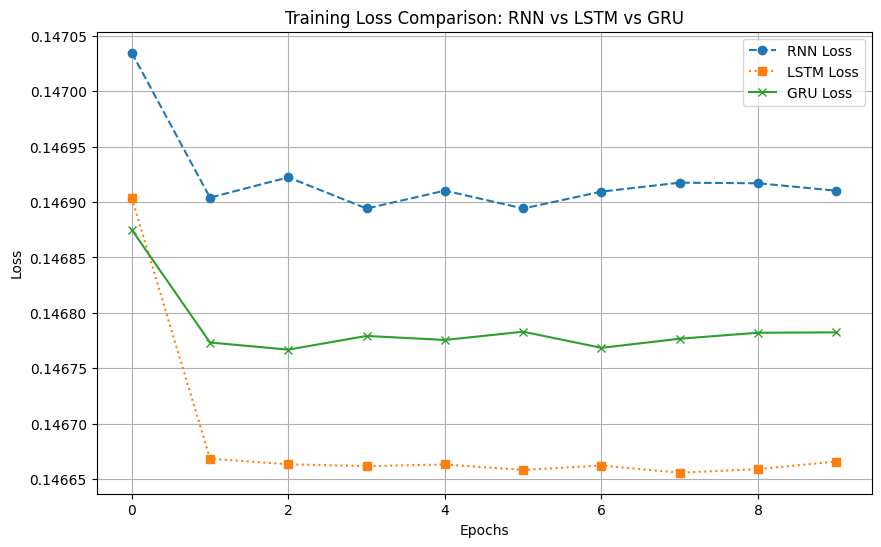

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32).unsqueeze(-1).to(device)

# Define the models
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return out

# Function to train models
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    losses = []
    model.train()
    model.to(device)
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}')
    return losses

# Define dataset and data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
input_size = X_train_tensor.shape[2]
hidden_size = 64
output_size = 1
learning_rate = 0.01

# Instantiate models
rnn_model = RNNModel(input_size, hidden_size, output_size).to(device)
lstm_model = LSTMModel(input_size, hidden_size, output_size).to(device)
gru_model = GRUModel(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizers
criterion = nn.BCEWithLogitsLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)

# Train models
print("Training RNN...")
rnn_losses = train_model(rnn_model, train_loader, criterion, rnn_optimizer)
print("Training LSTM...")
lstm_losses = train_model(lstm_model, train_loader, criterion, lstm_optimizer)
print("Training GRU...")
gru_losses = train_model(gru_model, train_loader, criterion, gru_optimizer)

# Plot Training Loss Curves
plt.figure(figsize=(10,6))
plt.plot(rnn_losses, label='RNN Loss', linestyle='dashed', marker='o')
plt.plot(lstm_losses, label='LSTM Loss', linestyle='dotted', marker='s')
plt.plot(gru_losses, label='GRU Loss', linestyle='solid', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: RNN vs LSTM vs GRU')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Select the first frame from the first frame
single_frame = X_test[0]

# Convert to PyTorch tensor and move to device
single_frame_tensor = torch.tensor(single_frame, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

# Make prediction
lstm_model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = lstm_model(single_frame_tensor)
    predicted_labels = torch.sigmoid(output).cpu().numpy()  # Convert output to probability



print(f"Predicted label for the single frame: {predicted_labels}")


Predicted label for the single frame: [[[0.03331724]
  [0.03511804]
  [0.03540222]
  [0.03544153]
  [0.03544688]
  [0.0354476 ]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]
  [0.03544771]]]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert test data to PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Make predictions for all test sequences
lstm_model.eval()
with torch.no_grad():
    outputs = lstm_model(X_test_tensor)
    predicted_labels = torch.sigmoid(outputs).cpu().numpy()
    predicted_labels = (predicted_labels > 0.5).astype(int)

# Flatten the arrays to compare predictions vs actual labels
y_test_flat = y_test.flatten()
predicted_labels_flat = predicted_labels.flatten()

# Compute evaluation metrics
accuracy = accuracy_score(y_test_flat, predicted_labels_flat)
precision = precision_score(y_test_flat, predicted_labels_flat, average='weighted')  # Use 'binary' for two classes
recall = recall_score(y_test_flat, predicted_labels_flat, average='weighted')  # Use 'macro' or 'micro' if needed
f1 = f1_score(y_test_flat, predicted_labels_flat, average='weighted')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, predicted_labels_flat)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Print classification report (gives per-class precision, recall, and F1-score)
print("\nClassification Report:")
print(classification_report(y_test_flat, predicted_labels_flat))


/home/japmyy/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/japmyy/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9664
Precision: 0.9340
Recall: 0.9664
F1 Score: 0.9499

Confusion Matrix:
[[2355586       0]
 [  81862       0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98   2355586
           1       0.00      0.00      0.00     81862

    accuracy                           0.97   2437448
   macro avg       0.48      0.50      0.49   2437448
weighted avg       0.93      0.97      0.95   2437448



/home/japmyy/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/japmyy/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch
from transformers import pipeline

# Manually set a different GPU (e.g., GPU 1 instead of GPU 0)
torch.cuda.set_device(1)  # Change to another GPU index

explainer = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-alpha", device=2)

prompt = "Explain the difference between RNN, LSTM, AND GRU, and which one is better than others."

explanation = explainer(prompt, max_length=100)

print(explanation[0]["generated_text"])


Loading checkpoint shards: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]
Device set to use cuda:2
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Explain the difference between RNN, LSTM, AND GRU, and which one is better than others.

RNN (Recurrent Neural Networks) is a type of neural network that can process sequences of data. It has a feedback connection that allows it to remember previous inputs and use them to predict the output for the current input. RNNs are useful for tasks such as speech recognition, machine translation, and sentiment analysis.

LSTM (Long Short
